In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.applications.efficientnet import EfficientNetB3
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt



C:\Users\saina\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load and preprocess the training data
train_df = pd.read_csv('C:\\Users\\saina\\OneDrive\\Desktop\\analytics vidhya\\train\\train.csv')
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image_path = os.path.join('C:\\Users\\saina\\OneDrive\\Desktop\\analytics vidhya\\train\\images', row['filename'])
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values
    train_images.append(image)
    train_labels.append(row['label'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)



In [3]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)


# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    train_images, train_labels_encoded, test_size=0.3, random_state=42)

In [4]:
# Model creation function
def create_model(image_input_shape):
    decay = 0.000001
    input_image = tf.keras.layers.Input(shape=image_input_shape)

    # Use EfficientNetB3 as the base model
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_image)
    x = base_model.output

    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    output_layer = Dense(n_class, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

    return model



In [5]:
# Define image input shape and number of classes
image_input_shape = (224, 224, 3)  # Adjust this based on your image dimensions
n_class=6




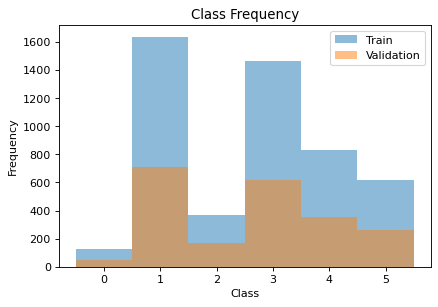

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Assuming y_train and y_val are label-encoded arrays
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')

# Plot class frequencies for y_train
plt.hist(y_train, bins=np.arange(0, 7) - 0.5, alpha=0.5, label='Train')

# Plot class frequencies for y_val
plt.hist(y_val, bins=np.arange(0, 7) - 0.5, alpha=0.5, label='Validation')

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 6))  # Assuming you have 6 classes
plt.legend(loc='best')

plt.show()


In [7]:
# Create the model
model = create_model(image_input_shape)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [8]:
# Train the model
history = model.fit(x_train, y_train, epochs=3, batch_size=64, validation_data=(x_val, y_val))

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(x_val, y_val)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')



Epoch 1/3


79/79 [==============================] - 1092s 12s/step - loss: 1.4684 - accuracy: 0.6494 - val_loss: 3.6192 - val_accuracy: 0.2852
Epoch 2/3
79/79 [==============================] - 959s 12s/step - loss: 0.4221 - accuracy: 0.8498 - val_loss: 4.5465 - val_accuracy: 0.3296
Epoch 3/3
68/68 [==============================] - 84s 1s/step - loss: 7.2906 - accuracy: 0.3222
Validation Accuracy: 32.22%


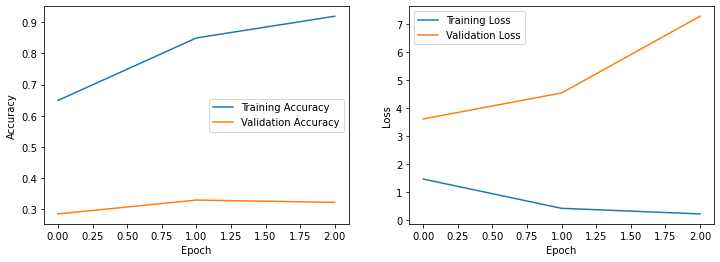

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


68/68 [==============================] - 75s 1s/step


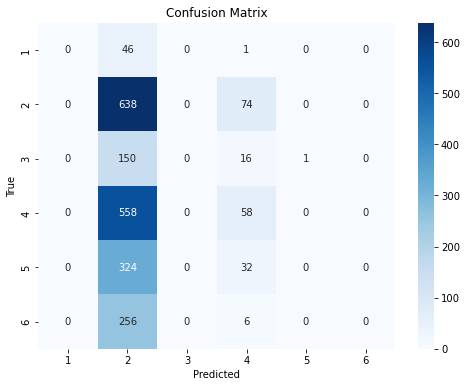

In [11]:
# Confusion Matrix
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [13]:
# Convert label_encoder.classes_ to a list of strings
class_names = [str(class_name) for class_name in label_encoder.classes_]

# Classification Report
class_report = classification_report(y_val, y_pred_classes, target_names=class_names)
print('Classification Report:\n', class_report)

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        47
           2       0.32      0.90      0.48       712
           3       0.00      0.00      0.00       167
           4       0.31      0.09      0.14       616
           5       0.00      0.00      0.00       356
           6       0.00      0.00      0.00       262

    accuracy                           0.32      2160
   macro avg       0.11      0.17      0.10      2160
weighted avg       0.20      0.32      0.20      2160



C:\Users\saina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# The Model is Overfitting 